In [98]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import physical_constants
from scipy.sparse import diags
from scipy.sparse.linalg import eigsh
import pandas as pd# Import necessary libraries
import numpy as np
import sympy as sp
from IPython.display import display, Math

import sys
sys.path.append('/workspaces/scribing/')
from colors import Bcolors as bc

# ⚠️⚠️⚠️⚠️Script still not properly rendering!

# Numerically solving for eigenstates and eigenvalues of an arbitrary 1D potential

Description: Obtain the energy eigenvalues $E_n$ and wavefunctions $\psi_n(r)$ for the anharmonic Morse potential (below). Note that value of the parameters correspond the hydrogen fluoride. Tabulate $E_n$ for $n=0$ to $5$, and plot the corresponding $\psi_n(r)$.

$$V = D_e [1-e^{-\alpha x}]^2$$
- **Equilibrium bond energy**:
    $$D=6.091\times10^{-19} \text{ J}$$
- **Equilibrium bond length**:
    $$r_0=9.109\times10^{-11} \text{ m}, \quad x=r-r_0$$
- **Force constant**:
    $$k=1.039\times10^{3} \ \text{J}\text{m}^{-2}, \quad \alpha=\sqrt{ k / 2D_e}$$

## Define constants in atomic units

In [99]:
# Import necessary libraries
import pandas as pd
from scipy.constants import physical_constants
from IPython.display import display, HTML

# Physical constants in SI units
hbar_SI = physical_constants['Planck constant over 2 pi'][0]  # J·s
m_e_SI = physical_constants['electron mass'][0]               # kg
a_0_SI = physical_constants['Bohr radius'][0]                 # m
E_h_SI = physical_constants['Hartree energy'][0]              # J

# Physical constants in atomic units
hbar_AU = 1    # Reduced Planck constant
m_e_AU = 5.4858e-4     # Atomic mass unit (Daltons)
a_0_AU = 1     # Bohr radius
E_h_AU = 1     # Hartree energy

# Create a dictionary with the physical constants
physical_constants_data = {
    'Constant': [
        r'hbar',
        r'm_e (electron mass)',
        r'a_0',
        r'E_h'
    ],
    'Value in SI Units': [hbar_SI, m_e_SI, a_0_SI, E_h_SI],
    'SI Units': ['J·s', 'kg', 'm', 'J'], 
    'Value in Atomic Units': [hbar_AU, m_e_AU, a_0_AU, E_h_AU],
    'AU Units': ['reduced Planck constant', 'Daltons', 'Bohr radius', 'Hartree energy']
}

# Create a DataFrame
df = pd.DataFrame(physical_constants_data)
df

,Constant,Value in SI Units,SI Units,Value in Atomic Units,AU Units
0,hbar,1.054572e-34,J·s,1.000000,reduced Planck constant
1,m_e (electron mass),9.109384e-31,kg,0.000549,Daltons
2,a_0,5.291772e-11,m,1.000000,Bohr radius
3,E_h,4.359745e-18,J,1.000000,Hartree energy


## Calculate $\alpha$ using the given $k$ and $D_e$
✨ Make sure to convert parameters into atomic units

In [100]:
import numpy as np
from scipy.constants import physical_constants

# Given values in SI units
k_SI = 1.039e3       # J/m^2
D_e_SI = 6.091e-19   # J
r_0_SI = 9.109e-11   # m

# Convert D_e to Hartree (atomic units)
D_e_AU = D_e_SI / E_h_SI
r_0_AU = r_0_SI / a_0_SI

# Correct conversion of k to atomic units
k_AU = k_AU * (a_0_AU**2) / E_h_AU  # Units: (J/m^2)*(m^2)/J = dimensionless

# Compute alpha in atomic units
alpha_AU = np.sqrt(k_AU / (2 * D_e_AU))

print(f"Equilibrium bond energy = {D_e_AU:.5f} daltons")
print(f"Force constant in atomic units = {k_AU:.5f} (unitless)")  
print(f"Alpha in atomic units = {alpha_AU:.5f}")

Equilibrium bond energy = 0.13971 daltons
Force constant in atomic units = 0.66735 (unitless)
Alpha in atomic units = 1.54543


## Reduced mass, $\mu$ of H-F molecule

$$\mu = \frac{m_\text{H} m_\text{F}}{m_\text{H} + m_\text{F}}

In [101]:
# Atomic mass in atomic mass units
m_H_AU = 1.00784     # atomic mass units
m_F_AU = 18.998403   # atomic mass units

mu_AU = (m_H_AU * m_F_AU) / (m_H_AU + m_F_AU)

# Reduced mass in atomic mass units (mu / m_e)
print(f"Reduced mass: {bc.GREEN}{mu_AU:.3e} atomic mass units{bc.ENDC}")

Reduced mass: 9.571e-01 atomic mass units


## Set up spatial grid

In [102]:
# Spatial range in atomic units (typically a few Bohr radii around equilibrium)
xmin = (-2e-10)/(a_0_SI)  # a_0
xmax = (5e-10)/(a_0_SI)   # a_0

N = 1000  # Increase N for better resolution
x = np.linspace(xmin, xmax, N)
dx = x[1] - x[0]

# Create a dictionary with the data, using raw strings for LaTeX expressions
physical_constants_data = {
    'Grid point/interval': [
        r'xmin',
        r'xmax',
        r'dx',
    ],
    'Value in AU Units': [xmin, xmax, dx],
    'Atomic Units': ['Bohr radii', 'Bohr radii', 'Bohr radii']
}

# Create a DataFrame
df = pd.DataFrame(physical_constants_data)
df

# Displacement from equilibrium position (already in atomic units)

,Grid point/interval,Value in AU Units,Atomic Units
0,xmin,-3.779452,Bohr radii
1,xmax,9.448631,Bohr radii
2,dx,0.013241,Bohr radii


## Calculate the potential $V(x)$ at each point on the grid

In [103]:
V_ii = D_e_AU * (1 - np.exp(-alpha_AU * x))**2   # V in Hartree units

# Set minimum value
V_floor = 1e-6  # Choose an appropriate floor value
V = np.maximum(V_ii, V_floor)

## Set up the kinetic energy operator ⚠️

In [104]:
# Construct the second derivative operator (kinetic energy term)
T_coeff = (hbar_AU**2) / (2 * mu_AU * dx**2)
diagonal = -2 * np.ones(N) * T_coeff
off_diagonal = (-1) * np.ones(N - 1) * T_coeff

# Assemble the kinetic energy matrix
from scipy.sparse import diags

T = diags([off_diagonal, diagonal, off_diagonal], offsets=[-1,0,1])
print(T)

<DIAgonal sparse matrix of dtype 'float64'
	with 2998 stored elements (3 diagonals) and shape (1000, 1000)>
  Coords	Values
  (1, 0)	-2979.6415339587747
  (2, 1)	-2979.6415339587747
  (3, 2)	-2979.6415339587747
  (4, 3)	-2979.6415339587747
  (5, 4)	-2979.6415339587747
  (6, 5)	-2979.6415339587747
  (7, 6)	-2979.6415339587747
  (8, 7)	-2979.6415339587747
  (9, 8)	-2979.6415339587747
  (10, 9)	-2979.6415339587747
  (11, 10)	-2979.6415339587747
  (12, 11)	-2979.6415339587747
  (13, 12)	-2979.6415339587747
  (14, 13)	-2979.6415339587747
  (15, 14)	-2979.6415339587747
  (16, 15)	-2979.6415339587747
  (17, 16)	-2979.6415339587747
  (18, 17)	-2979.6415339587747
  (19, 18)	-2979.6415339587747
  (20, 19)	-2979.6415339587747
  (21, 20)	-2979.6415339587747
  (22, 21)	-2979.6415339587747
  (23, 22)	-2979.6415339587747
  (24, 23)	-2979.6415339587747
  (25, 24)	-2979.6415339587747
  :	:
  (974, 975)	-2979.6415339587747
  (975, 976)	-2979.6415339587747
  (976, 977)	-2979.6415339587747
  (977, 978)	-2

## Construct the Hamiltonian Matrix
Combine the kinetic and potential energy terms

In [105]:
# Potential energy matrix (diagonal matrix)
V_matrix = diags(V, 0, format='csr')

# Hamiltonian matrix
H = T + V_matrix

# Convert to a dense matrix:
H = H.toarray()

Ensure no NaNs or infinities:

In [106]:
import numpy as np

if np.isnan(H.data).any() or np.isinf(H.data).any():
    print("Hamiltonian contains NaNs or Infinities.")
else:
    print("Hamiltonian matrix is valid.")

Hamiltonian matrix is valid.


Check the magnitudes of matrix elements:

In [107]:
H_data = np.array(H.data)
max_element = np.max(np.abs(H_data))
non_zero_elements = H_data[H_data != 0]  # This extracts all non-zero elements

min_element = np.min(np.abs(non_zero_elements))
print(f"Max Hamiltonian element: {max_element}")
print(f"Min non-zero Hamiltonian element: {min_element}")

Max Hamiltonian element: 10485.403764581668
Min non-zero Hamiltonian element: 71.21894016234637


## Solving the Schrodinger Equation ⚠️

In [108]:
from scipy.sparse.linalg import eigsh

# Number of eigenvalues and eigenvectors to compute
num_eigenvalues = 6

# Compute the lowest eigenvalues and corresponding eigenvectors
eigenvalues, eigenvectors = eigsh(H, k=num_eigenvalues, which='SA', tol=1e-5, maxiter=10000)

# 'which' parameter:
# 'SA' - compute the smallest algebraic eigenvalues
# 'SM' - may not work properly with sparse matrices and complex potentials

## Converting Eigenvalues to Physical Units

In [109]:
# Eigenvalues are already in Joules
E_n = eigenvalues   # J

## Normalizing the Eigenfunctions ⚠️
Normalize the eigenfunctions so that the integral over all space is 1

In [110]:
# Normalize eigenfunctions
psi_n = []
for i in range(num_eigenvalues):
    psi = eigenvectors[:, i]
    
    # Normalize
    norm = np.sqrt(np.sum(np.abs(psi)**2) + dx)    
    psi_n.append(psi / norm) 

## Tabulate the Energy Eigenvalues

In [111]:
import pandas as pd 

data = {'n': np.arange(num_eigenvalues), 'E_n (J)': E_n}
df = pd.DataFrame(data)
print(df)

   n       E_n (J)
0  0 -11918.392426
1  1 -11918.269071
2  2 -11918.046637
3  3 -11917.730200
4  4 -11917.324246
5  5 -11916.831382


## Plot the Wavefunctions

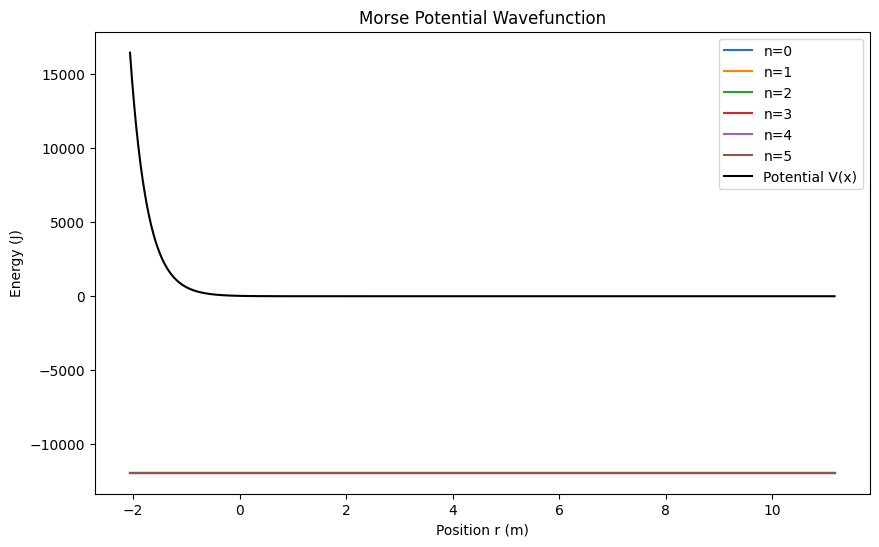

In [112]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10, 6))
for i in range(num_eigenvalues):
    plt.plot(x + r_0_AU, psi_n[i] + E_n[i], label=f'n={i}')
    
# Plot the potential for reference
plt.plot(x + r_0_AU, V, 'k-', label='Potential V(x)')

plt.xlabel('Position r (m)')
plt.ylabel('Energy (J)')
plt.title('Morse Potential Wavefunction')
plt.legend()
plt.show()